In [93]:
# Packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

In [94]:
# Setup

all_player =  pd.read_csv("all_seasons.csv", index_col="Rk")
all_player = all_player[['player_name', 'college']]
all_player.rename(columns={'player_name': 'Player'}, inplace=True)
all_player = all_player.drop_duplicates(subset=['Player'])
contract = pd.read_csv("sportsref_download.csv", index_col="Rk")
contract = contract[['Player', 'Tm', '2023-24', 'Guaranteed']]
APtop25_colleges = [
    "Kentucky", "North Carolina", "Duke", "Kansas", "UCLA", "Louisville",
    "Arizona", "Indiana", "Michigan State", "Ohio State", "Syracuse",
    "Cincinnati", "Michigan", "Illinois", "Villanova", "Notre Dame",
    "Purdue", "Maryland", "Marquette", "Georgetown", "Gonzaga", "Oklahoma",
    "Utah", "UConn", "Arkansas"
]
round2_colleges = [
    "NC State", "Iowa", "Kansas State", "UNLV", "Oklahoma State",
    "Virginia", "West Virginia", "St. John’s", "Memphis", "Bradley",
    "Wake Forest", "Alabama", "DePaul", "Missouri", "Wisconsin",
    "Pitt", "Houston", "Florida", "Wisconsin", "Texas",
    "Florida State", "LSU", "San Francisco", "Stanford", "Minnesota"
]

In [95]:
# Clean Data
main_data = pd.merge(all_player, contract, on='Player')
main_data = main_data.drop_duplicates(subset=['Player'])
main_data['2023-24'] = main_data['2023-24'].replace('[\$,]', '', regex=True).astype(float)
main_data['Guaranteed'] = main_data['Guaranteed'].replace('[\$,]', '', regex=True).astype(float)
top_25_colleges = main_data[main_data['college'].isin(APtop25_colleges)]
non_top_25_colleges = main_data[~main_data['college'].isin(APtop25_colleges)]
nonn_top_25_colleges = main_data[main_data['college'].isin(round2_colleges)]

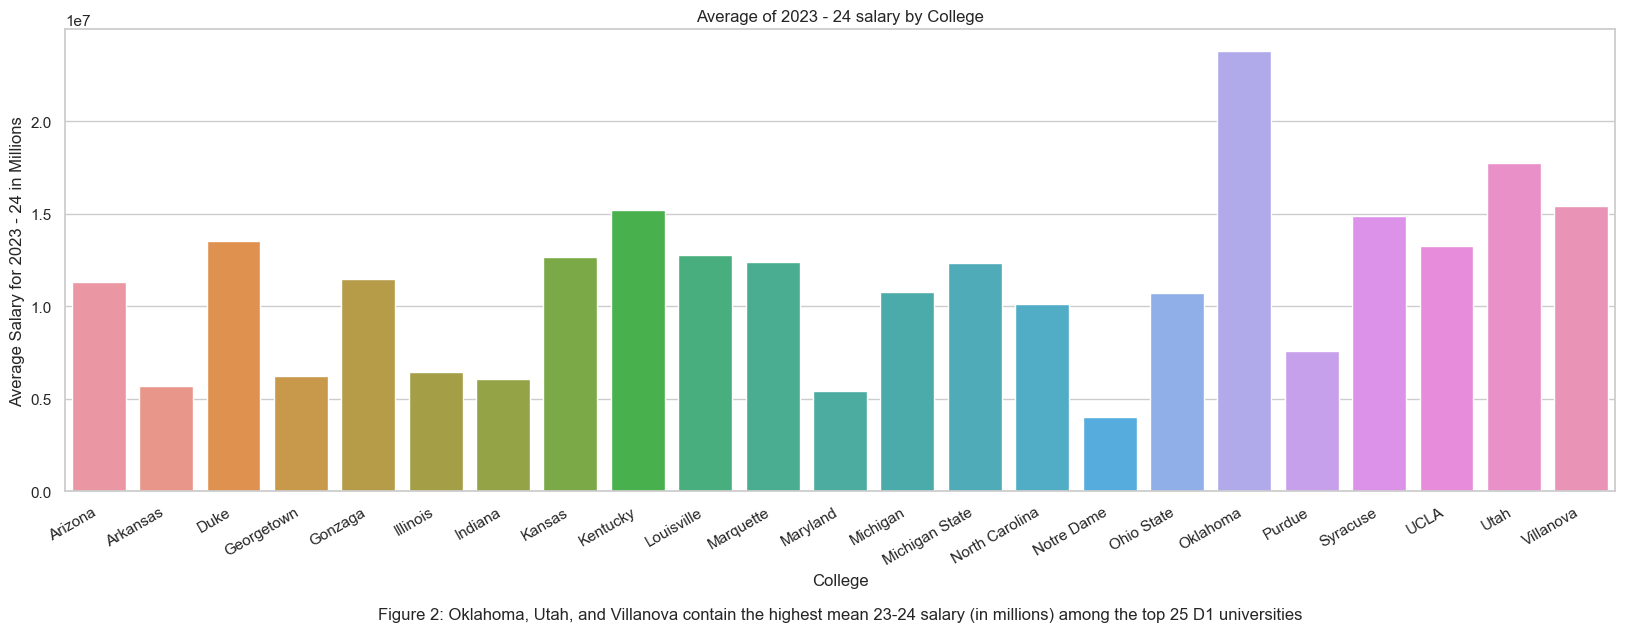

In [96]:
# Figure 1
college_averages = top_25_colleges.groupby('college')['2023-24'].mean().reset_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 6))
ax = sns.barplot(x='college', y='2023-24', data=college_averages)
ax.set_title('Average of 2023 - 24 salary by College')
ax.set_xlabel('College')
ax.set_ylabel('Average Salary for 2023 - 24 in Millions')
plt.xticks(rotation=30, ha='right')
plt.text(0.5, -0.25, "Figure 2: Oklahoma, Utah, and Villanova contain the highest mean 23-24 salary (in millions) among the top 25 D1 universities",
         fontsize=12, ha='center', va='top', transform=ax.transAxes)
plt.show()

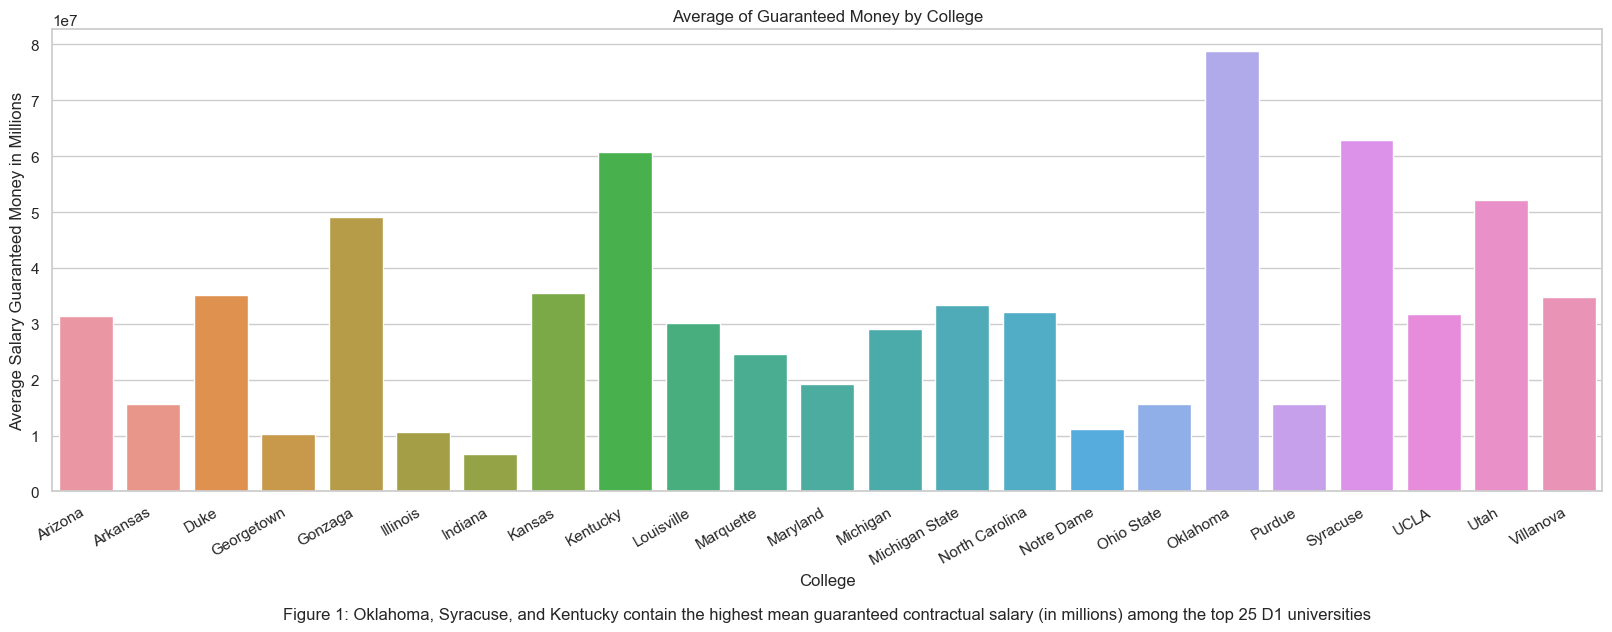

In [97]:
# Figure 2
college_averages = top_25_colleges.groupby('college')['Guaranteed'].mean().reset_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 6))
ax = sns.barplot(x='college', y='Guaranteed', data=college_averages)
ax.set_title('Average of Guaranteed Money by College')
ax.set_xlabel('College')
ax.set_ylabel('Average Salary Guaranteed Money in Millions')
plt.text(0.5, -0.25, "Figure 1: Oklahoma, Syracuse, and Kentucky contain the highest mean guaranteed contractual salary (in millions) among the top 25 D1 universities",
         fontsize=12, ha='center', va='top', transform=ax.transAxes)
plt.xticks(rotation=30, ha='right')
plt.show()

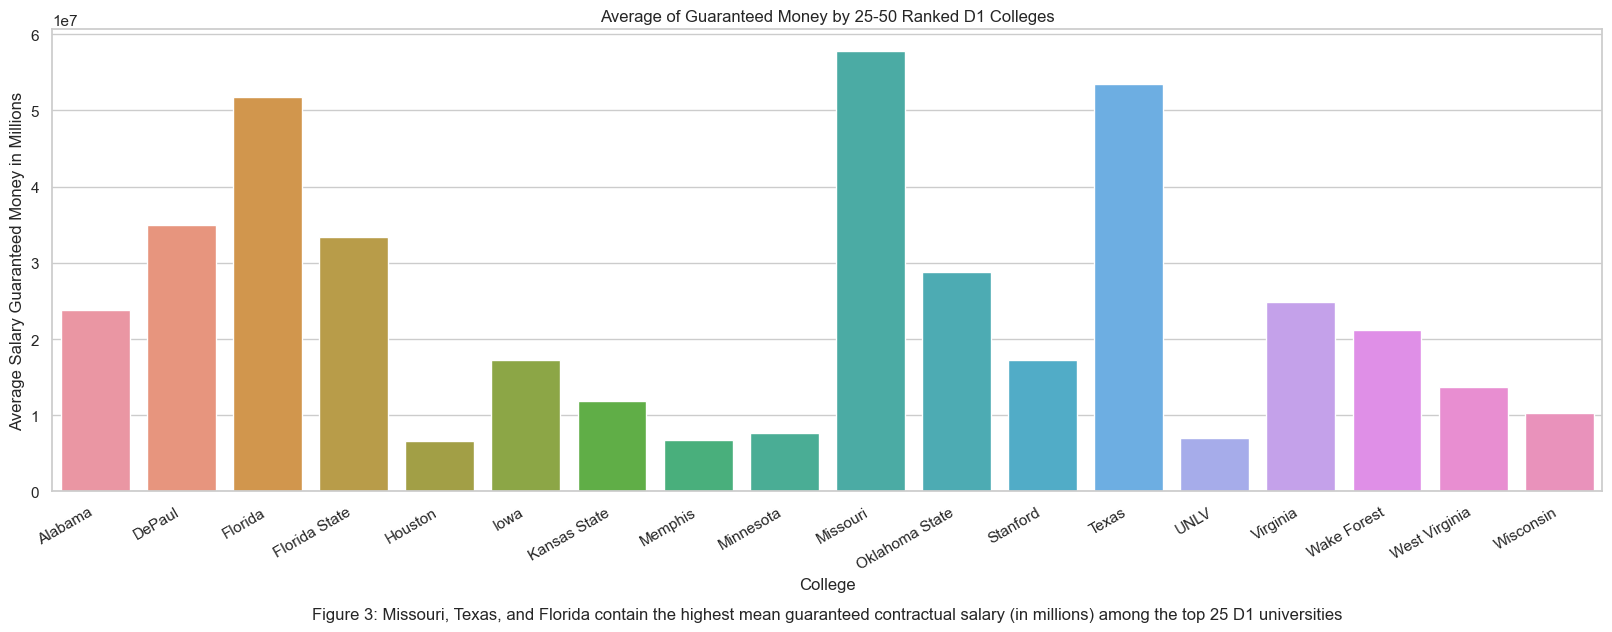

In [98]:
#Shows 25-50 D1 universities plot for highest mean guaranteed contractual salary

contractual_non25 = nonn_top_25_colleges.groupby('college')['Guaranteed'].mean().reset_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 6))
ax = sns.barplot(x='college', y='Guaranteed', data=contractual_non25)
ax.set_title('Average of Guaranteed Money by 25-50 Ranked D1 Colleges')
ax.set_xlabel('College')
ax.set_ylabel('Average Salary Guaranteed Money in Millions')
plt.xticks(rotation=30, ha='right')
plt.text(0.5, -0.25, "Figure 3: Missouri, Texas, and Florida contain the highest mean guaranteed contractual salary (in millions) among the top 25 D1 universities",
         fontsize=12, ha='center', va='top', transform=ax.transAxes)

plt.show()

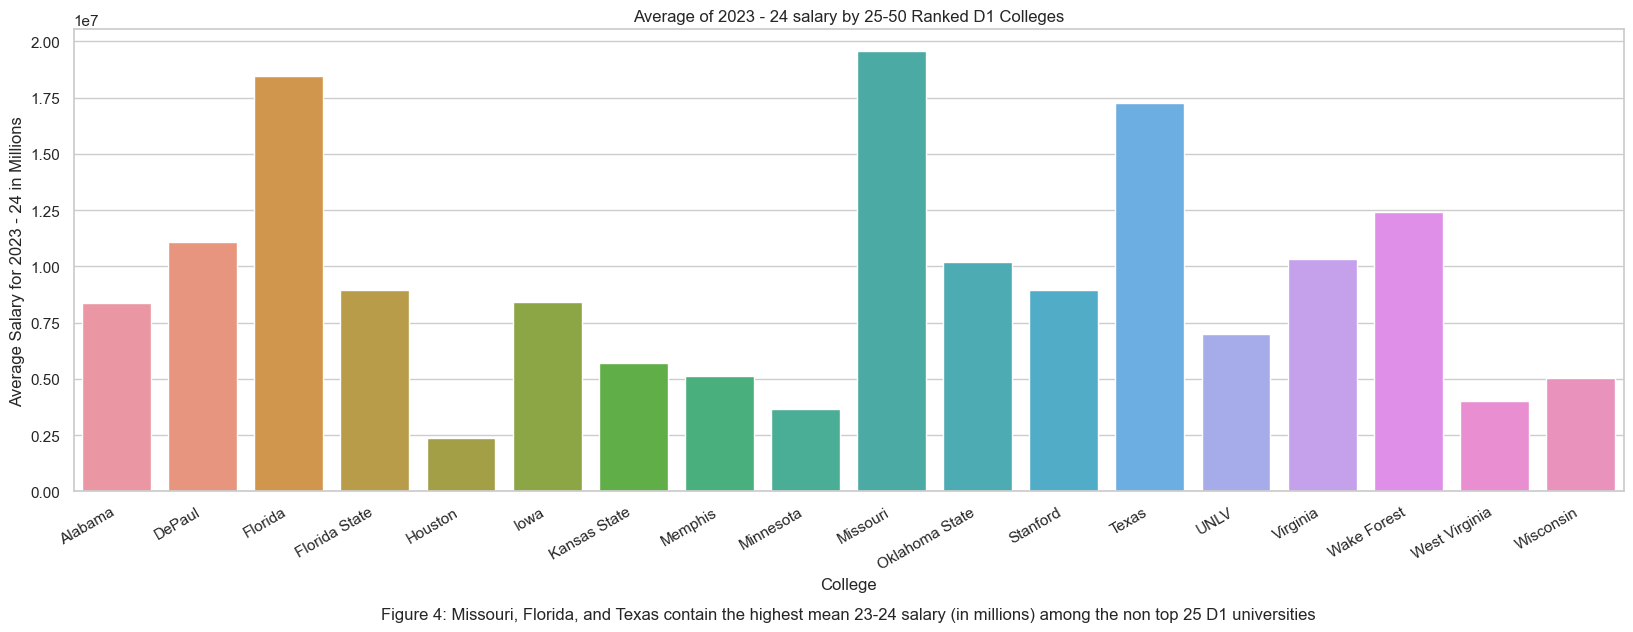

In [105]:
#Shows 25-50 D1 universities plot for highest mean seasonal 23-24 salary

seasonal_non25 = nonn_top_25_colleges.groupby('college')['2023-24'].mean().reset_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 6))
ax = sns.barplot(x='college', y='2023-24', data=seasonal_non25)
ax.set_title('Average of 2023 - 24 salary by 25-50 Ranked D1 Colleges')
ax.set_xlabel('College')
ax.set_ylabel('Average Salary for 2023 - 24 in Millions')
plt.xticks(rotation=30, ha='right')
plt.text(0.5, -0.25, "Figure 4: Missouri, Florida, and Texas contain the highest mean 23-24 salary (in millions) among the non top 25 D1 universities",
         fontsize=12, ha='center', va='top', transform=ax.transAxes)

plt.show()

In [100]:
# Bootstrap Function
def bootstrap_diff_means(data1, data2, n_iterations):
    size1 = len(data1)
    size2 = len(data2)
    bootstrapped_means_diff = []
    
    for i in range(n_iterations):
        sample1 = np.nanmean(np.random.choice(data1, size=size1, replace=True))
        sample2 = np.nanmean(np.random.choice(data2, size=size2, replace=True))
        mean_diff = sample1 - sample2   
        bootstrapped_means_diff.append(mean_diff)
        
    return np.array(bootstrapped_means_diff)
   

In [101]:
# Guarnteed Bootstrap

np.random.seed(12345678)
top_25_salaries = top_25_colleges['Guaranteed'].values
non_top_25_salaries = non_top_25_colleges['Guaranteed'].values

mean_salary_top_25 = np.nanmean(top_25_salaries)
mean_salary_non_top_25 = np.nanmean(non_top_25_salaries)

observed_diff = mean_salary_top_25 - mean_salary_non_top_25
diff_means = bootstrap_diff_means(top_25_salaries, non_top_25_salaries, 10000)


conf_int = np.percentile(diff_means, [2.5, 97.5])

null_mu = 0
p_value = 2 * (1 - norm.cdf(np.abs(np.mean(diff_means)), loc=null_mu, scale=np.std(diff_means)))

print("Observed Difference in Mean Guaranteed: {:.2f}".format(observed_diff))
print("95% Confidence Interval: [{:.2f}, {:.2f}]".format(conf_int[0], conf_int[1]))
print("P-Value: {:.4f}".format(p_value))

Observed Difference in Mean Guaranteed: 10810958.89
95% Confidence Interval: [1353654.08, 20586249.79]
P-Value: 0.0286


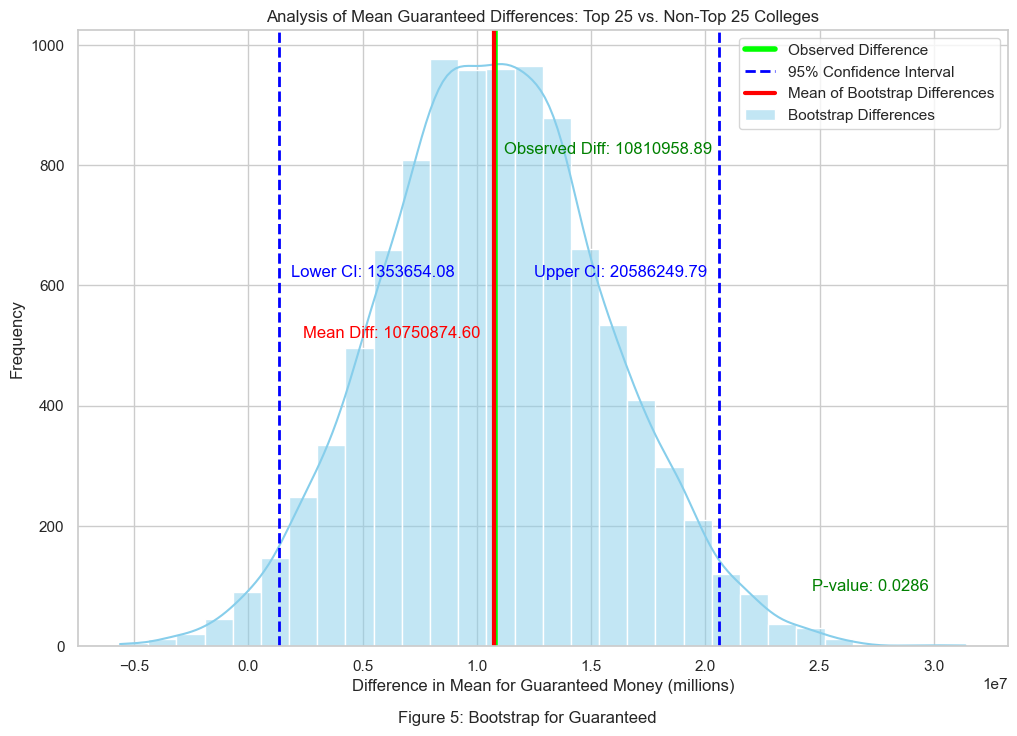

In [102]:
# Figure 5
plt.figure(figsize=(12, 8))
sns.histplot(diff_means, bins=30, kde=True, color='skyblue', label='Bootstrap Differences')
plt.axvline(x=observed_diff, color='lime', linestyle='-', linewidth=4, label='Observed Difference')
plt.axvline(x=conf_int[0], color='blue', linestyle='--', linewidth=2, label='95% Confidence Interval')
plt.axvline(x=conf_int[1], color='blue', linestyle='--', linewidth=2)
plt.axvline(x=np.mean(diff_means), color='red', linestyle='-', linewidth=3, label='Mean of Bootstrap Differences')
plt.xlabel('Difference in Mean for Guaranteed Money (millions)')
plt.ylabel('Frequency')
plt.title('Analysis of Mean Guaranteed Differences: Top 25 vs. Non-Top 25 Colleges')
plt.legend()


plt.text(x=observed_diff + 9500000, y=plt.gca().get_ylim()[1]*0.8, s=f"Observed Diff: {observed_diff:.2f}", horizontalalignment='right', color='green')
plt.text(x=conf_int[1] - 500000, y=plt.gca().get_ylim()[1]*0.6, s=f"Upper CI: {conf_int[1]:.2f}", horizontalalignment='right', color='blue')
plt.text(x=conf_int[0] + 500000, y=plt.gca().get_ylim()[1]*0.6, s=f"Lower CI: {conf_int[0]:.2f}", horizontalalignment='left', color='blue')
plt.text(x=np.mean(diff_means) - 4500000, y=plt.gca().get_ylim()[1]*0.5, s=f"Mean Diff: {np.mean(diff_means):.2f}", horizontalalignment='center', color='red')
plt.text(x=conf_int[1] + 9200000, y=plt.gca().get_ylim()[1]*0.09, s=f"P-value: {p_value:.4f}", horizontalalignment='right', color='green')
plt.figtext(0.5, 0.01, "Figure 5: Bootstrap for Guaranteed", ha="center", va="bottom", fontsize=12)


plt.show()

In [103]:
# Salary Bootstrap

np.random.seed(12345678)

i_top_25_salaries = top_25_colleges['2023-24'].values
i_non_top_25_salaries = non_top_25_colleges['2023-24'].values

i_mean_salary_top_25 = np.nanmean(i_top_25_salaries)
i_mean_salary_non_top_25 = np.nanmean(i_non_top_25_salaries)

i_observed_diff = i_mean_salary_top_25 - i_mean_salary_non_top_25
i_diff_means = bootstrap_diff_means(i_top_25_salaries, i_non_top_25_salaries, 10000)


i_conf_int = np.percentile(i_diff_means, [2.5, 97.5])

i_null_mu = 0
i_p_value = 2 * (1 - norm.cdf(np.abs(np.mean(i_diff_means)), loc=null_mu, scale=np.std(i_diff_means)))

print("Observed Difference in Mean Salaries: {:.2f}".format(i_observed_diff))
print("95% Confidence Interval: [{:.2f}, {:.2f}]".format(i_conf_int[0], i_conf_int[1]))
print("P-Value: {:.4f}".format(i_p_value))

Observed Difference in Mean Salaries: 3146924.49
95% Confidence Interval: [952022.28, 5282553.36]
P-Value: 0.0046


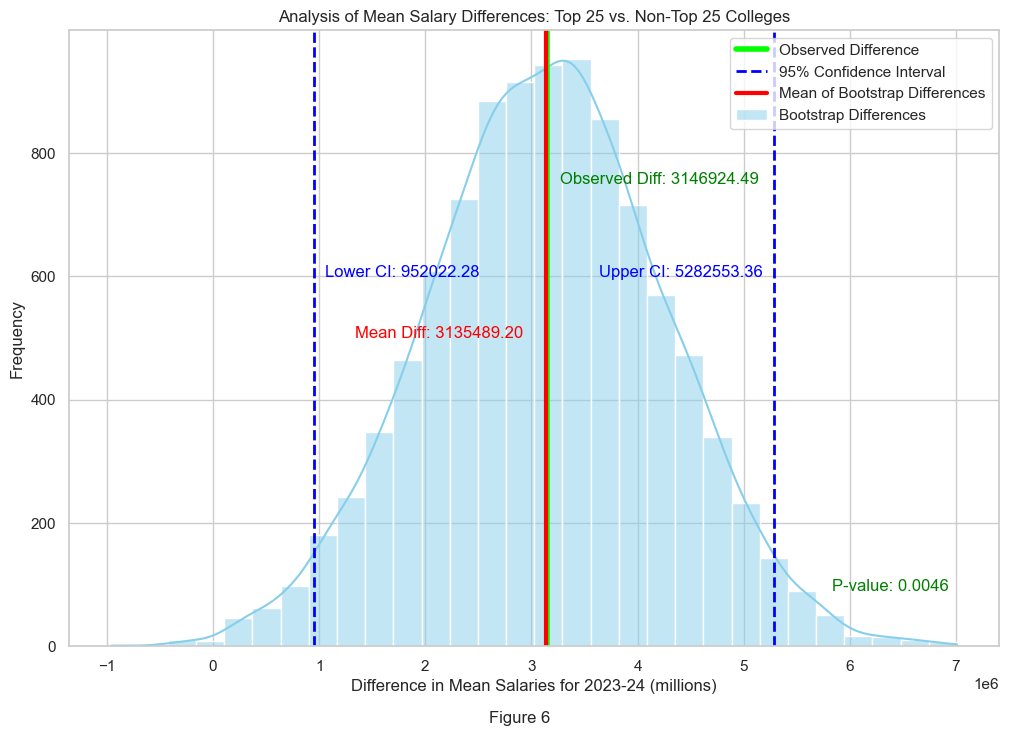

In [104]:
# Figure 6

plt.figure(figsize=(12, 8))
sns.histplot(i_diff_means, bins=30, kde=True, color='skyblue', label='Bootstrap Differences')
plt.axvline(x=i_observed_diff, color='lime', linestyle='-', linewidth=4, label='Observed Difference')
plt.axvline(x=i_conf_int[0], color='blue', linestyle='--', linewidth=2, label='95% Confidence Interval')
plt.axvline(x=i_conf_int[1], color='blue', linestyle='--', linewidth=2)
plt.axvline(x=np.mean(i_diff_means), color='red', linestyle='-', linewidth=3, label='Mean of Bootstrap Differences')
plt.xlabel('Difference in Mean Salaries for 2023-24 (millions)')
plt.ylabel('Frequency')
plt.title('Analysis of Mean Salary Differences: Top 25 vs. Non-Top 25 Colleges')
plt.legend()


plt.text(x=i_observed_diff + 2000000, y=plt.gca().get_ylim()[1]*0.75, s=f"Observed Diff: {i_observed_diff:.2f}", horizontalalignment='right', color='green')
plt.text(x=i_conf_int[1] - 100000, y=plt.gca().get_ylim()[1]*0.6, s=f"Upper CI: {i_conf_int[1]:.2f}", horizontalalignment='right', color='blue')
plt.text(x=i_conf_int[0] + 100000, y=plt.gca().get_ylim()[1]*0.6, s=f"Lower CI: {i_conf_int[0]:.2f}", horizontalalignment='left', color='blue')
plt.text(x=np.mean(i_diff_means) - 1010000, y=plt.gca().get_ylim()[1]*0.5, s=f"Mean Diff: {np.mean(i_diff_means):.2f}", horizontalalignment='center', color='red')
plt.text(x=i_conf_int[1] + 1655000, y=plt.gca().get_ylim()[1]*0.09, s=f"P-value: {i_p_value:.4f}", horizontalalignment='right', color='green')
plt.figtext(0.5, 0.01, "Figure 6", ha="center", va="bottom", fontsize=12)
plt.show()